In [27]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc
import pickle
import gameOfLife

In [28]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
device = torch.device("cuda:0") #Подрубайтунг

In [30]:
train_folder = "gl/" #да да там
size = 30

In [31]:
def saveState(data, name, epoch):
    with open('gl/'+str(name)+"_"+str(epoch)+".gl", 'wb') as f:
        pickle.dump(data, f)
        
def readState(name, epoch):
    with open('gl/'+str(name)+"_"+str(epoch)+".gl", 'rb') as f:
        return pickle.load(f)
    
def showGame(result, delay = 45):
    exit = False
    while not exit:
        for i in range(len(result)):
            img = np.zeros([size, size, 3], dtype=float)
            img[:,:,0] = result[i]*0.1
            img[:,:,1] = result[i]*0.4
            img[:,:,2] = result[i]*0.9

            #vis2 = cv2.cvtColor(result[i].astype(np.float32), cv2.COLOR_GRAY2BGR)
            resized = cv2.resize(img, (600, 600), 0, 0, interpolation = cv2.INTER_NEAREST)
            cv2.imshow("game", resized)
            key = cv2.waitKey(delay) 
            if key!=-1:
                exit = True
                break

    cv2.destroyAllWindows() 

In [32]:
class GameOfLifeDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder
        
        files = os.listdir(self.folder)
        
        self.count = len(files)
        self.games_path = list()
        
        for f in os.listdir(self.folder):
            self.games_path.append(f)

    def __len__(self):
        return self.count

    def __getitem__(self, index):
        path = self.games_path[index]
        game, epoch = path.split('.')[0].split('_')
        
        cur_step = readState(game, epoch)
        next_step = gameOfLife.computeStep(cur_step)
        if self.transform is not None:
            cur_step = self.transform(cur_step)
            next_step = self.transform(next_step)

        return cur_step, next_step, index

In [33]:
train_dataset = GameOfLifeDataset(train_folder, transform=transforms.Compose([transforms.ToTensor(),]))

In [34]:
batch_size = 10

data_size = len(train_dataset)
print(data_size)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)

400


In [35]:
def plotResults(loss_history, trainAcc, valAcc):
    colors = ['#06d6a0', '#277da1', '#ee6c4d','#5a189a','#f3722c']
    fig, axs = plt.subplots(2)
    fig.set_size_inches(12, 7)

    axs[0].plot(loss_history, label = "loss", color = colors[0])
    axs[0].grid()
    axs[0].legend()
    
    axs[1].plot(trainAcc, label = "train accuracy", color = colors[1])
    axs[1].plot(valAcc, label = "validation accuracy", color = colors[2])
    axs[1].grid()
    axs[1].legend()

In [59]:
import copy

def compute_accuracy(model, loader, device):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()  # Evaluation mode

    correct = 0
    total = 0
    with torch.no_grad():
        for i_step, (x, y, _) in enumerate(loader):
            x, y = x.float(), y.float()
            prediction = model(x.to(device)).cpu()
            #print(prediction.shape)

            for i in range(x.shape[0]):
                for j in range(x.shape[1]):
                    y_data = y[i][j]
                    pred_data = np.around(prediction[i][j])
                    countMap = map(lambda x, y: 1 if x==y else 0, y_data.reshape(-1), pred_data.reshape(-1))
                    #print(pred_data)

                    correct += sum(list(countMap))/(y_data.shape[0]*y_data.shape[1])
                    total += 1
                    
            del prediction
    
    return float(correct)/total

def train_model_v2(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
            x=x.float()
            y=y.float()
            
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            for i in range(x.shape[0]):
                for j in range(x.shape[1]):
                    y_data = y[i][j]
                    pred_data = np.around(prediction.cpu().detach().numpy()[i][j])
                    countMap = map(lambda x, y: 1 if x==y else 0, y_data.reshape(-1), pred_data.reshape(-1))
                    #print(pred_data)

                    correct_samples += sum(list(countMap))/(y_data.shape[0]*y_data.shape[1])
                    total_samples += 1
            
            loss_accum += loss_value
            
        ave_loss = loss_accum / i_step
        
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader, device)
        
        if scheduler is not None:
            scheduler.step(ave_loss)
            
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        

In [88]:
model = nn.Sequential(
            nn.Conv2d(1, 12, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 24, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24, 12, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 1, 3, padding=1),
)
model.type(torch.cuda.FloatTensor)
model.to(device)

Sequential(
  (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): Conv2d(12, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [89]:
loss = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
sheduler = optim.lr_scheduler.StepLR(optimizer , step_size=4, gamma=0.8)
loss_history, train_history, val_history = train_model_v2(model, train_loader, val_loader, loss, optimizer, 50, sheduler)

c:\users\neo\appdata\local\programs\python\python38\lib\site-packages\torch\optim\lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Average loss: 0.104128, Train accuracy: 0.840639, Val accuracy: 0.851264
Average loss: 0.087059, Train accuracy: 0.870260, Val accuracy: 0.885722
Average loss: 0.081064, Train accuracy: 0.883674, Val accuracy: 0.885167
Average loss: 0.071749, Train accuracy: 0.894535, Val accuracy: 0.894792
Average loss: 0.063928, Train accuracy: 0.916653, Val accuracy: 0.940514
Average loss: 0.044153, Train accuracy: 0.961431, Val accuracy: 0.974736
Average loss: 0.030658, Train accuracy: 0.987056, Val accuracy: 0.991972
Average loss: 0.022048, Train accuracy: 0.991500, Val accuracy: 0.993347
Average loss: 0.030536, Train accuracy: 0.990851, Val accuracy: 0.990694
Average loss: 0.018368, Train accuracy: 0.990528, Val accuracy: 0.991528
Average loss: 0.015322, Train accuracy: 0.992729, Val accuracy: 0.994486
Average loss: 0.014120, Train accuracy: 0.993427, Val accuracy: 0.995625
Average loss: 0.012904, Train accuracy: 0.995184, Val accuracy: 0.993472
Average loss: 0.012165, Train accuracy: 0.995337, V

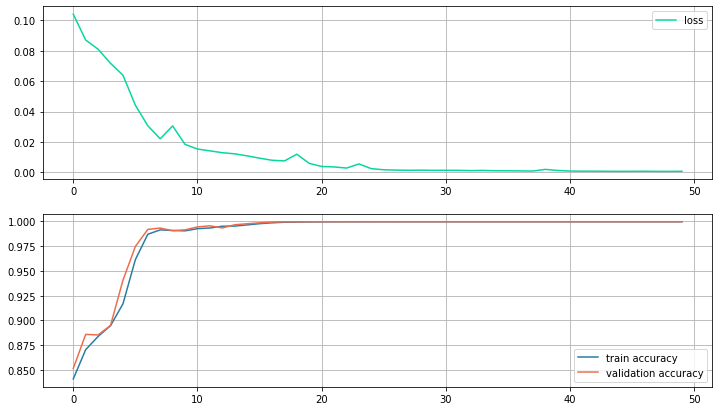

In [90]:
plotResults(loss_history, train_history, val_history)

In [91]:
def nnNextStep(inp):
    trans = transforms.Compose([transforms.ToTensor(),])
    inp = trans(inp).unsqueeze(0).float().to(device)
    res = model(inp).cpu()
    res = np.around(res[0][0].detach().numpy())
    #print(res)
    return res

In [93]:
#showGame([nnNextStep(np.random.choice([0, 1], p=[0.8, 0.2], size=(size, size)))])

In [94]:
def show2Games(result1, result2, delay = 45):
    exit = False
    while not exit:
        for i in range(len(result1)):
            img = np.zeros([size, size, 3], dtype=float)
            img[:,:,0] = result1[i]*0.1
            img[:,:,1] = result1[i]*0.4
            img[:,:,2] = result1[i]*0.9

            #vis2 = cv2.cvtColor(result[i].astype(np.float32), cv2.COLOR_GRAY2BGR)
            resized = cv2.resize(img, (600, 600), 0, 0, interpolation = cv2.INTER_NEAREST)
            cv2.imshow("real game", resized)
            
            #----
            img = np.zeros([size, size, 3], dtype=float)
            img[:,:,0] = result2[i]*0.9
            img[:,:,1] = result2[i]*0.4
            img[:,:,2] = result2[i]*0.1

            #vis2 = cv2.cvtColor(result[i].astype(np.float32), cv2.COLOR_GRAY2BGR)
            resized = cv2.resize(img, (600, 600), 0, 0, interpolation = cv2.INTER_NEAREST)
            cv2.imshow("nn game", resized)
            
            key = cv2.waitKey(delay) 
            if key!=-1:
                exit = True
                break

    cv2.destroyAllWindows() 
def showNNGame():
    startGrid = np.random.choice([0, 1], p=[0.8, 0.2], size=(size, size))
    res = []  #nn game
    res2 = [] #real game
    
    res.append(nnNextStep(startGrid))
    res2.append(gameOfLife.computeStep(startGrid))
    for i in range(1, 50):
        res.append(nnNextStep(res[i-1]))
        res2.append(gameOfLife.computeStep(res2[i-1]))
    show2Games(res2, res, 90)

In [95]:
showNNGame()